# E-Commerce Delivery EDA


### Content
The dataset used for model building contained 10999 observations of 12 variables.
The data contains the following information:

- ID: ID Number of Customers.
- Warehouse block: The Company have big Warehouse which is divided in to block such as A,B,C,D,E.
- Mode of shipment:The Company Ships the products in multiple way such as Ship, Flight and Road.
- Customer care calls: The number of calls made from enquiry for enquiry of the shipment.
- Customer rating: The company has rated from every customer. 1 is the lowest (Worst), 5 is the highest (Best).
- Cost of the product: Cost of the Product in US Dollars.
- Prior purchases: The Number of Prior Purchase.
- Product importance: The company has categorized the product in the various parameter such as low, medium, high.
- Gender: Male and Female.
- Discount offered: Discount offered on that specific product.
- Weight in gms: It is the weight in grams.
- Reached on time: It is the target variable, where 1 Indicates that the product has NOT reached on time and 0 indicates it has reached on time. (Its best to think of it as we want predict if the shipment will be late)

In [1]:
import pandas as pd
import numpy as np
from mygraphs import create_boxplots, create_histograms, create_graphs, create_boxplots2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, auc
from lazypredict.Supervised import LazyClassifier

## Initialize the dataframe, etc...

In [2]:
df = pd.read_csv('Data//train.csv')

In [3]:
df.head()

ID Warehouse_block Mode_of_Shipment  Customer_care_calls  Customer_rating  \
0   1               D           Flight                    4                2   
1   2               F           Flight                    4                5   
2   3               A           Flight                    2                2   
3   4               B           Flight                    3                3   
4   5               C           Flight                    2                2   

   Cost_of_the_Product  Prior_purchases Product_importance Gender  \
0                  177                3                low      F   
1                  216                2                low      M   
2                  183                4                low      M   
3                  176                4             medium      M   
4                  184                3             medium      F   

   Discount_offered  Weight_in_gms  Reached.on.Time_Y.N  
0                44           1233                    1  
1                59           3088                    1  
2                48           3374                    1  
3                10           1177                    1  
4                46           2484                    1

In [4]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


In [5]:
# create_boxplots(df, 4)

In [6]:
# create_graphs(df, 3)

### The distributions are odd in Prior_purchases, Discount_offered and Weight_in_gms.  However there is no reason to change them at this time, we'll later look at correlations

### No missingness found in the DF, no NaN type encoding hidden in the categorical variables

In [7]:
# sns.pairplot(df, hue='Reached.on.Time_Y.N', diag_kind='kde')
# plt.show()

In [8]:
print(df[df['Discount_offered'] >= 10]['Reached.on.Time_Y.N'].value_counts())
print(df[df['Discount_offered'] > 10]['Reached.on.Time_Y.N'].value_counts())

1    3048
0     459
Name: Reached.on.Time_Y.N, dtype: int64
1    2647
Name: Reached.on.Time_Y.N, dtype: int64


### Problem: for 'Discount_offered' > $10, there are no deliveries that were on time!
- This suggests that any 'Discount_offered' > 10 was given after the knowledge that the delivery was not going to be on time, thus can't be used as a predictor.

In [9]:
# dropping the column but keeping the rows
df = df.drop(columns='Discount_offered', axis=1)

In [10]:
# sns.pairplot(df, hue='Reached.on.Time_Y.N', diag_kind='kde')
# plt.show()

### It appears that there data source is not pulled from a normal distribution, with respect to the weight_in_grams.  For instance:
- Up until ID 3135, there are essentiall zero values above 4000.  Then after ID~3135 there are only values 1-2k and 4-6k
- Cost_of_the_product has a hole for the 2-4k wieght range between 0 and ~175, then again for >2k wieght for cost > ~275
- Most importantly, there is a hole in our target variable Reached.on.Time_Y.N=0 for weights ~2000 to 4000 and ID 0 ~3000!

Due to this apparent strangeness/missingness in the distribution, we should not use weight as a predictor

In [11]:
# dropping ID (as it is just a sequence number and should not be used as a predictor)
df = df.drop(columns=['ID'], axis=1)

In [12]:
# create_boxplots2(df, 4)

In [13]:
# # Generate heat map of correlations
# corr = df.corr()

# mask = np.triu(np.ones_like(corr, dtype=bool))

# # Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(11, 9))

# # Generate a custom diverging colormap
# cmap = sns.diverging_palette(230, 20, as_cmap=True)

# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})

# plt.show()

### Correlations:
- Almost no correlation with any X variable to the target variable.


In [14]:
# # Create a 2x2 grid of subplots
# fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# # Assign each countplot to a subplot in the grid
# sns.countplot(x='Warehouse_block', hue='Reached.on.Time_Y.N', data=df, ax=axs[0, 0])
# sns.countplot(x='Mode_of_Shipment', hue='Reached.on.Time_Y.N', data=df, ax=axs[0, 1])
# sns.countplot(x='Product_importance', hue='Reached.on.Time_Y.N', data=df, ax=axs[1, 0])
# sns.countplot(x='Gender', hue='Reached.on.Time_Y.N', data=df, ax=axs[1, 1])

# # Adjust layout for better readability
# plt.tight_layout()

# # Display the plots
# plt.show()


### Categorical variables Warehouse_block=F, Mode_of_shipment='Ship' seem to have the biggest signal in the target

## Some feature engineering...

## Create feature sets, target sets

In [25]:
# Split the data into X and y
X = df.drop('Reached.on.Time_Y.N', axis=1)
y = df['Reached.on.Time_Y.N']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Define the transformer
# Specify the columns to be one-hot encoded ('x', 'y', 'z') and the transformer (OneHotEncoder) to use on them
cat_columns = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']
column_transformer = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(), cat_columns)
    ],
    remainder='passthrough'
)

## Fit the transformer on the training data only and transform X_train
X_train_encoded = column_transformer.fit_transform(X_train)

# Transform X_test using the already fitted transformer
X_test_encoded = column_transformer.transform(X_test)

# Get the new column names after one-hot encoding
encoded_columns = column_transformer.named_transformers_['encoder'].get_feature_names_out(cat_columns)
new_columns = list(encoded_columns) + [col for col in X.columns if col not in cat_columns]

# Convert the transformed arrays back to DataFrames
X_train = pd.DataFrame(X_train_encoded, columns=new_columns, index=X_train.index)
X_test = pd.DataFrame(X_test_encoded, columns=new_columns, index=X_test.index)
X_names = X_test.columns


In [26]:
X_train

Warehouse_block_A  Warehouse_block_B  Warehouse_block_C  \
8965                0.00               0.00               0.00   
5936                1.00               0.00               0.00   
10656               0.00               0.00               0.00   
3328                0.00               0.00               1.00   
9880                0.00               0.00               1.00   
...                  ...                ...                ...   
5734                0.00               0.00               1.00   
5191                0.00               0.00               0.00   
5390                1.00               0.00               0.00   
860                 1.00               0.00               0.00   
7270                0.00               0.00               1.00   

       Warehouse_block_D  Warehouse_block_F  Mode_of_Shipment_Flight  \
8965                0.00               1.00                     0.00   
5936                0.00               0.00                     0.00   
10656               1.00               0.00                     0.00   
3328                0.00               0.00                     0.00   
9880                0.00               0.00                     1.00   
...                  ...                ...                      ...   
5734                0.00               0.00                     0.00   
5191                0.00               1.00                     0.00   
5390                0.00               0.00                     0.00   
860                 0.00               0.00                     0.00   
7270                0.00               0.00                     1.00   

       Mode_of_Shipment_Road  Mode_of_Shipment_Ship  Product_importance_high  \
8965                    0.00                   1.00                     0.00   
5936                    0.00                   1.00                     0.00   
10656                   0.00                   1.00                     0.00   
3328                    0.00                   1.00                     0.00   
9880                    0.00                   0.00                     0.00   
...                      ...                    ...                      ...   
5734                    1.00                   0.00                     0.00   
5191                    1.00                   0.00                     0.00   
5390                    0.00                   1.00                     0.00   
860                     0.00                   1.00                     0.00   
7270                    0.00                   0.00                     1.00   

       Product_importance_low  Product_importance_medium  Gender_F  Gender_M  \
8965                     1.00                       0.00      1.00      0.00   
5936                     0.00                       1.00      1.00      0.00   
10656                    0.00                       1.00      0.00      1.00   
3328                     0.00                       1.00      0.00      1.00   
9880                     1.00                       0.00      1.00      0.00   
...                       ...                        ...       ...       ...   
5734                     1.00                       0.00      1.00      0.00   
5191                     0.00                       1.00      1.00      0.00   
5390                     0.00                       1.00      1.00      0.00   
860                      0.00                       1.00      1.00      0.00   
7270                     0.00                       0.00      1.00      0.00   

       Customer_care_calls  Customer_rating  Cost_of_the_Product  \
8965                  3.00             5.00               178.00   
5936                  6.00             3.00               202.00   
10656                 2.00             5.00               277.00   
3328                  5.00             5.00               219.00   
9880                  6.00             3.00               296.00   
...                

## Baseline Model: Decision Tree Classifier with Max_depth=8

In [27]:

tree_model = DecisionTreeClassifier(random_state=42, max_depth=8)
tree_model.fit(X_train, y_train)
y_pred_train = tree_model.predict(X_train)
y_pred_test = tree_model.predict(X_test)

## Baseline Model Results:

In [28]:

print('TRAINING SET CLASSIFICATION REPORT')
print(classification_report(y_train, y_pred_train))
print('-------------------------------------')
print('TEST SET CLASSIFICATION REPORT')
print(classification_report(y_test, y_pred_test))
print('-------------------------------------')

TRAINING SET CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.58      0.96      0.73      3541
           1       0.95      0.54      0.69      5258

    accuracy                           0.71      8799
   macro avg       0.77      0.75      0.71      8799
weighted avg       0.80      0.71      0.70      8799

-------------------------------------
TEST SET CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.57      0.92      0.70       895
           1       0.91      0.52      0.66      1305

    accuracy                           0.68      2200
   macro avg       0.74      0.72      0.68      2200
weighted avg       0.77      0.68      0.68      2200

-------------------------------------


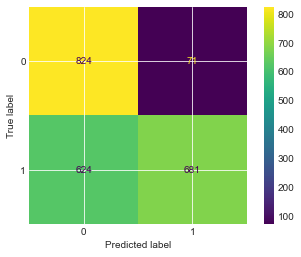

In [29]:
conf_matrix = confusion_matrix(y_test, y_pred_test)
cmd = ConfusionMatrixDisplay(conf_matrix)
cmd.plot();

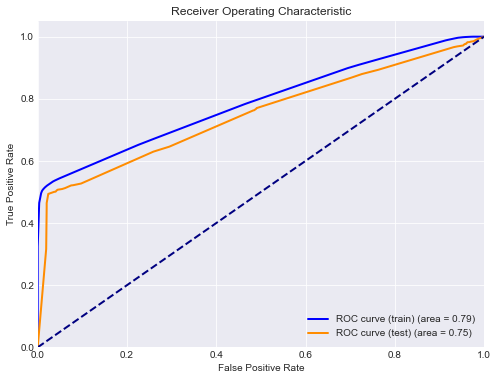

In [30]:

y_prob_train = tree_model.predict_proba(X_train)[:, 1]
fpr_train, tpr_train, thresh_train = roc_curve(y_train, y_prob_train)
roc_auc_train = auc(fpr_train, tpr_train)

y_prob_test = tree_model.predict_proba(X_test)[:, 1]
fpr_test, tpr_test, thresh_test = roc_curve(y_test, y_prob_test)
roc_auc_test = auc(fpr_test, tpr_test)

# Plotting both ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='ROC curve (train) (area = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC curve (test) (area = %0.2f)' % roc_auc_test)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Decision Tree Classifier Model - With 'Manual' Hyperparameter Tuning

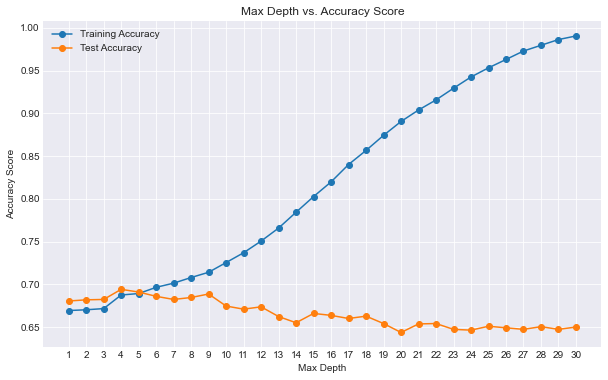

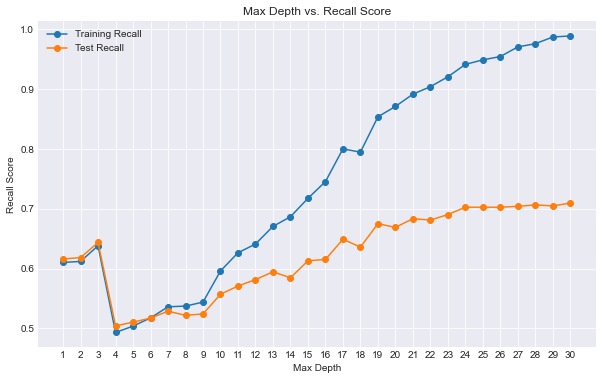

In [31]:
plt.style.use('seaborn-darkgrid')

acc_train = []
recall_train = []
acc_test = []
recall_test = []
x_range = np.arange(1, 31, 1)

for max_depth in x_range:
    model = DecisionTreeClassifier(criterion='gini', random_state=45, max_depth=max_depth)
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    acc_train.append(accuracy_score(y_train, y_pred_train))
    recall_train.append(recall_score(y_train, y_pred_train))
    acc_test.append(accuracy_score(y_test, y_pred_test))
    recall_test.append(recall_score(y_test, y_pred_test))


# Create a new figure for Recall
plt.figure(figsize=(10, 6))
plt.plot(x_range, acc_train, label='Training Accuracy', marker='o')
plt.plot(x_range, acc_test, label='Test Accuracy', marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy Score')
plt.title('Max Depth vs. Accuracy Score')
plt.xticks(x_range)  # Set x-axis ticks to be x_range values
plt.legend()
plt.show()

# Create a new figure for AUC
plt.figure(figsize=(10, 6))
plt.plot(x_range, recall_train, label='Training Recall', marker='o')
plt.plot(x_range, recall_test, label='Test Recall', marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Recall Score')
plt.title('Max Depth vs. Recall Score')
plt.xticks(x_range)  # Set x-axis ticks to be x_range values
plt.legend()
plt.show()


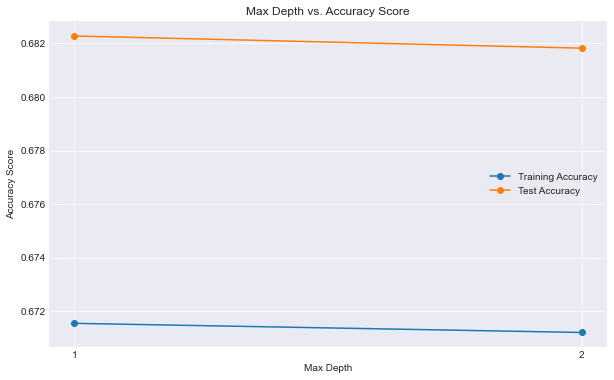

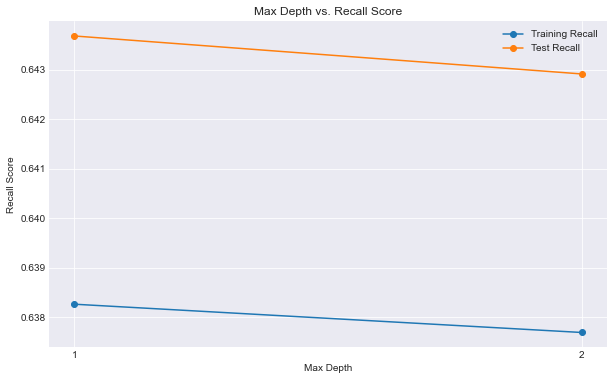

In [32]:


acc_train = []
recall_train = []
acc_test = []
recall_test = []
x_range = np.arange(1, 3, 1)

for criterion in ['gini', 'entropy']:
    model = DecisionTreeClassifier(random_state=45, max_depth=3, criterion=criterion)
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    acc_train.append(accuracy_score(y_train, y_pred_train))
    recall_train.append(recall_score(y_train, y_pred_train))
    acc_test.append(accuracy_score(y_test, y_pred_test))
    recall_test.append(recall_score(y_test, y_pred_test))


# Create a new figure for Recall
plt.figure(figsize=(10, 6))
plt.plot(x_range, acc_train, label='Training Accuracy', marker='o')
plt.plot(x_range, acc_test, label='Test Accuracy', marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy Score')
plt.title('Max Depth vs. Accuracy Score')
plt.xticks(x_range)  # Set x-axis ticks to be x_range values
plt.legend()
plt.show()

# Create a new figure for AUC
plt.figure(figsize=(10, 6))
plt.plot(x_range, recall_train, label='Training Recall', marker='o')
plt.plot(x_range, recall_test, label='Test Recall', marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Recall Score')
plt.title('Max Depth vs. Recall Score')
plt.xticks(x_range)  # Set x-axis ticks to be x_range values
plt.legend()
plt.show()


In [33]:
# Trying logistic regresssion for a baseline model
tree_model = DecisionTreeClassifier(random_state=42, max_depth=3, criterion='gini')
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

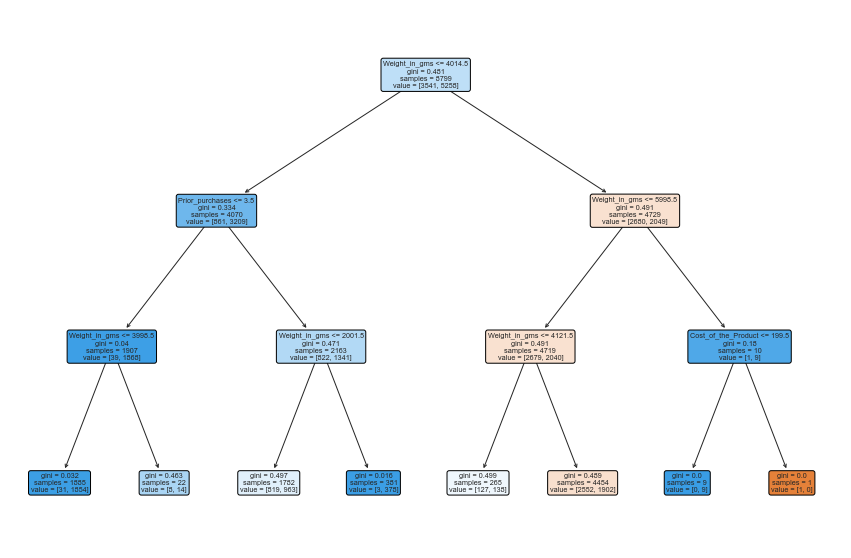

In [34]:
#plt.rcParams['figure.dpi'] = 900  # e.g. 300, 600, 1200
plt.figure(figsize=(15,10))  # Set the figure size
plot_tree(tree_model, feature_names=X_names, filled=True, rounded=True)
plt.show()


In [35]:
y_pred_train = tree_model.predict(X_train)
y_pred_test = tree_model.predict(X_test)
print('TRAINING SET CLASSIFICATION REPORT')
print(classification_report(y_train, y_pred_train))
print('-------------------------------------')
print('TEST SET CLASSIFICATION REPORT')
print(classification_report(y_test, y_pred_test))
print('-------------------------------------')

TRAINING SET CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.57      0.72      0.64      3541
           1       0.77      0.64      0.70      5258

    accuracy                           0.67      8799
   macro avg       0.67      0.68      0.67      8799
weighted avg       0.69      0.67      0.67      8799

-------------------------------------
TEST SET CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.59      0.74      0.65       895
           1       0.78      0.64      0.71      1305

    accuracy                           0.68      2200
   macro avg       0.68      0.69      0.68      2200
weighted avg       0.70      0.68      0.69      2200

-------------------------------------


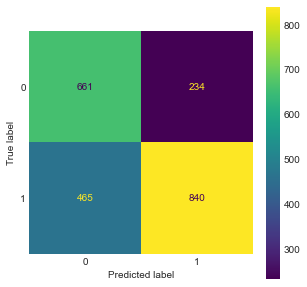

In [36]:
# Assuming y_test and y_pred_test are defined
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Create a figure and a set of subplots with custom size
fig, ax = plt.subplots(figsize=(5, 5))  # Adjust the figure size as needed

# Plot the confusion matrix on the created axes
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(ax=ax)  # Pass the axes to the plot method

plt.grid(False)  # Disable the grid
plt.show()

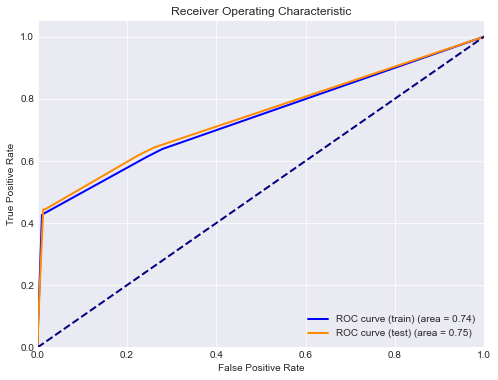

In [37]:
y_prob_train = tree_model.predict_proba(X_train)[:, 1]
fpr_train, tpr_train, thresh_train = roc_curve(y_train, y_prob_train)
roc_auc_train = auc(fpr_train, tpr_train)

y_prob_test = tree_model.predict_proba(X_test)[:, 1]
fpr_test, tpr_test, thresh_test = roc_curve(y_test, y_prob_test)
roc_auc_test = auc(fpr_test, tpr_test)

# Plotting both ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='ROC curve (train) (area = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC curve (test) (area = %0.2f)' % roc_auc_test)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Not good results for the baseline model. Very much over-fitted; the training set is perfect and the test set is barely better than coin-flip.

## Grid Search Best Decision Tree Params

In [38]:
# Define parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 10),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 5),
    'class_weight': ['balanced', None]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv=5, scoring='recall')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Evaluate on Test Data
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Best Parameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Score: 0.6264779514711681
Test Accuracy: 0.6822727272727273


In [39]:
# Trying logistic regresssion for grid search model
tree_model = DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_leaf=1, min_samples_split=2, class_weight=None, random_state=42)
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

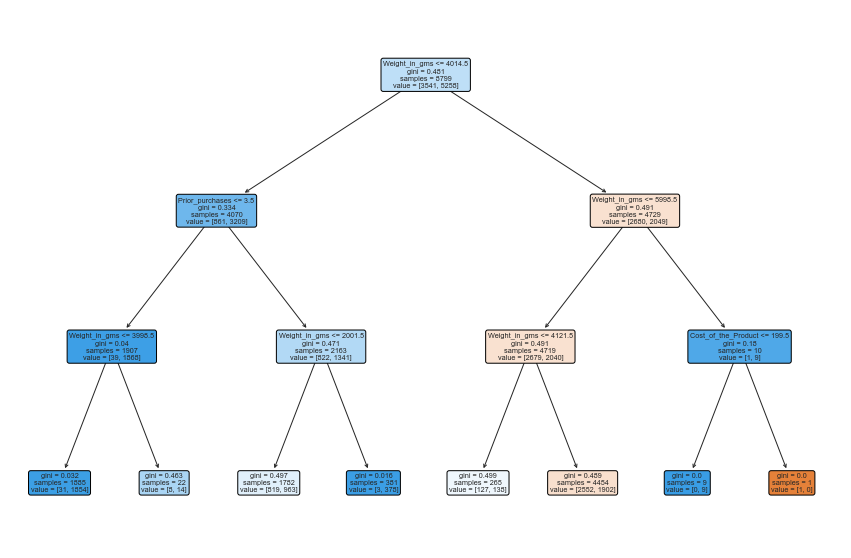

In [40]:
plt.figure(figsize=(15,10))  # Set the figure size
plot_tree(tree_model, feature_names=X_names, filled=True, rounded=True)
plt.show()


In [41]:
y_pred_train = tree_model.predict(X_train)
y_pred_test = tree_model.predict(X_test)
print('TRAINING SET CLASSIFICATION REPORT')
print(classification_report(y_train, y_pred_train))
print('-------------------------------------')
print('TEST SET CLASSIFICATION REPORT')
print(classification_report(y_test, y_pred_test))
print('-------------------------------------')
print(f'test_accuracy: {accuracy_score(y_test, y_pred_test)}')
print(f'test_recall: {recall_score(y_test, y_pred_test)}')
print(f'test_precision: {precision_score(y_test, y_pred_test)}')


TRAINING SET CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.57      0.72      0.64      3541
           1       0.77      0.64      0.70      5258

    accuracy                           0.67      8799
   macro avg       0.67      0.68      0.67      8799
weighted avg       0.69      0.67      0.67      8799

-------------------------------------
TEST SET CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.59      0.74      0.65       895
           1       0.78      0.64      0.71      1305

    accuracy                           0.68      2200
   macro avg       0.68      0.69      0.68      2200
weighted avg       0.70      0.68      0.69      2200

-------------------------------------
test_accuracy: 0.6822727272727273
test_recall: 0.6436781609195402
test_precision: 0.7821229050279329


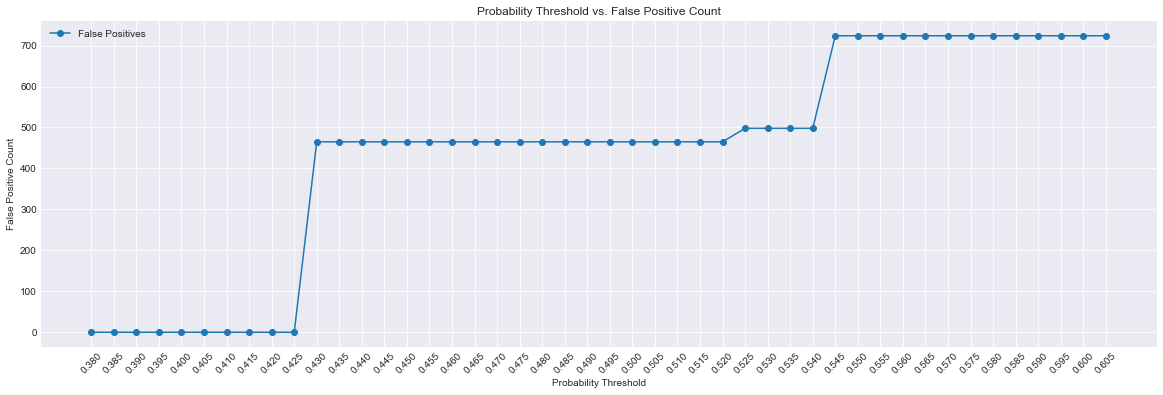

In [42]:
y_test_prob = tree_model.predict_proba(X_test)[:, 1]
FN = []
x_range = np.arange(0.38, 0.61, 0.005)
for prob_threshold in x_range:    
    y_pred_test = (y_test_prob > prob_threshold).astype(int)
    conf_matrix = confusion_matrix(y_test, y_pred_test)
    FN.append(conf_matrix[1][0])

# Create a new figure for AUC
plt.figure(figsize=(20, 6))
plt.plot(x_range, FN, label='False Positives', marker='o')
plt.xlabel('Probability Threshold')
plt.ylabel('False Positive Count')
plt.title('Probability Threshold vs. False Positive Count')
plt.xticks(x_range)  # Set x-axis ticks to be x_range values

plt.xticks(rotation=45)
plt.legend()
plt.show()

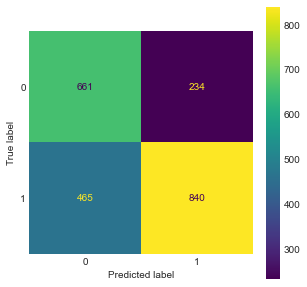

In [43]:

prob_threshold = 0.50
y_test_prob = tree_model.predict_proba(X_test)[:, 1]
y_pred_test = (y_test_prob > prob_threshold).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred_test)
# Create a figure and a set of subplots with custom size
fig, ax = plt.subplots(figsize=(5, 5))  # Adjust the figure size as needed

# Plot the confusion matrix on the created axes
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(ax=ax)  # Pass the axes to the plot method

plt.grid(False)  # Disable the grid
plt.show()

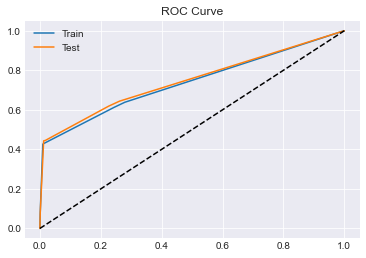

In [44]:
y_test_score = tree_model.predict_proba(X_test)[:, 1]
y_train_score = tree_model.predict_proba(X_train)[:, 1]

test_fpr, test_tpr, thresholds = roc_curve(y_test, y_test_score)
train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score)

# Plot the ROC curves
plt.plot(train_fpr, train_tpr, label='Train')
plt.plot(test_fpr, test_tpr, label='Test')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()
plt.title('ROC Curve')
plt.show()

### Use the LazyClassifier to identify other high performing models to evaluate

In [74]:


clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)

100%|██████████| 29/29 [00:20<00:00,  1.43it/s]

[LightGBM] [Info] Number of positive: 5258, number of negative: 3541
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 531
[LightGBM] [Info] Number of data points in the train set: 8799, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.597568 -> initscore=0.395342
[LightGBM] [Info] Start training from score 0.395342
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.67               0.68     0.68      0.67   
BaggingClassifier                  0.67               0.67     0.67      0.67   
XGBClassifier                      0.66               0.66     0.66      0.66   
RandomForestClassifier             0.66    

## Grid Search LGBMClassifier

In [79]:
#instantiate LGBMClassifier
from lightgbm import LGBMClassifier
estimator = LGBMClassifier(random_state=42)

# Define parameter grid
param_grid = {
    'num_leaves': [31, 63, 127, 255],
    'max_depth': [-1, 10, 20, 40],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200, 500]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=5, scoring='recall')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Evaluate on Test Data
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

[LightGBM] [Info] Number of positive: 4207, number of negative: 2832
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 516
[LightGBM] [Info] Number of data points in the train set: 7039, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.597670 -> initscore=0.395767
[LightGBM] [Info] Start training from score 0.395767
[LightGBM] [Info] Number of positive: 4206, number of negative: 2833
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 516
[LightGBM] [Info] Number of data points in the train set: 7039, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.597528 -> initscore=0.395176
[LightGBM] [I

Best Parameters: {'learning_rate': 0.001, 'max_depth': -1, 'n_estimators': 50, 'num_leaves': 31}
Best Score: 1.0
Test Accuracy: 0.5931818181818181

Best Parameters: {'max_depth': -1, 'num_leaves': 175}
Best Score: 0.6764942314579994
Test Accuracy: 0.6527272727272727

In [ ]:
# Define the models and parameter grids
models_and_parameters = {
    'RandomForestClassifier': (RandomForestClassifier(), 
                               {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20, 30]}),
    # 'SVC': (SVC(), 
    #         {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}),
    'LogisticRegression': (LogisticRegression(), 
                           {'C': [0.1, 1, 10]}),
    'DecisionTreeClassifier': (DecisionTreeClassifier(), 
                           {'criterion': ['gini', 'entropy'],
                            'max_depth': range(1, 10),
                            'min_samples_split': range(2, 10),
                            'min_samples_leaf': range(1, 5)})
}

# Iterate over models and their parameter grids
for model_name, (model, param_grid) in models_and_parameters.items():
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='recall')
    grid_search.fit(X_train, y_train)
    print(f"{model_name}: Best Score: {grid_search.best_score_}, Best Params: {grid_search.best_params_}")